In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


In [3]:
#load Dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [4]:
import numpy as np

print("y_train shape:", y_train.shape)
print("num classes:", len(np.unique(y_train)))
print("min/max label:", y_train.min(), y_train.max())

y_train shape: (50000, 1)
num classes: 100
min/max label: 0 99


In [5]:
# Convert NumPy arrays into a tf.data pipeline (yields (image, label) pairs)

ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [6]:
# Data augmentation
def data_augment(image,label):
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_hue(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

  return image, label

In [7]:
# Preprocessing
def preprocessing(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5)-1
  image = tf.image.resize(image, (227,227))

  return image , label

In [8]:
# prepare pipline
def prepare_pip(ds, augment=False, shuffle=False):
  ds = ds.shuffle(buffer_size=10000) if shuffle else ds
  ds = ds.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE) if augment else ds
  ds = ds.map(preprocessing, num_parallel_calls = tf.data.AUTOTUNE)
  ds = ds.batch(batch_size=100)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

In [9]:
# Preprocess the data
train_ds = prepare_pip(ds_train, augment=True, shuffle=True)
test_ds = prepare_pip(ds_test, augment=False, shuffle=False)

## Implement *AlexNet*

In [10]:
from tensorflow.keras.regularizers import l2

# L2 Regularization (Weight Decay)
wd = 1e-4

model = Sequential([
    tf.keras.Input(shape=(227, 227, 3)),
    layers.Conv2D(96, (11,11), padding='same', strides=(4,4), activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.MaxPool2D((3,3), strides=(2,2)),

    layers.Conv2D(256, (5,5), padding='same', strides=(1,1), activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.MaxPool2D((3,3), strides=(2,2)),

    layers.Conv2D(384, (3,3), padding='same', strides=(1,1), activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Conv2D(256, (3,3), padding='same', strides=(1,1), activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.MaxPool2D((3,3), strides=(2,2)),

    layers.Flatten(),

    layers.Dense(4096, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Dense(4096, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Dropout(0.7),
    layers.Dense(100, activation='softmax', kernel_regularizer=l2(wd))
])

model.compile(
    optimizer= tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.01, nesterov=True),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 57, 57, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       409,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,363,556 (218.82 MB)

 Trainable params: 57,363,556 (218.82 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-5
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True
)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.0416 - loss: 6.2691 - val_accuracy: 0.1672 - val_loss: 5.3569 - learning_rate: 0.0100
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - accuracy: 0.1570 - loss: 5.3954 - val_accuracy: 0.2696 - val_loss: 4.7751 - learning_rate: 0.0100
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 116ms/step - accuracy: 0.2446 - loss: 4.8899 - val_accuracy: 0.3468 - val_loss: 4.3545 - learning_rate: 0.0100
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - accuracy: 0.3152 - loss: 4.4952 - val_accuracy: 0.3973 - val_loss: 4.1093 - learning_rate: 0.0100
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.3689 - loss: 4.2276 - val_accuracy: 0.4232 - val_loss: 3.9493 - learning_rate: 0.0100
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - accuracy: 0.4023 - loss: 4.0155 - val_accuracy: 0.4506 - val_loss: 3.8370 - learning_rate: 0.0100
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 114ms/step - accura

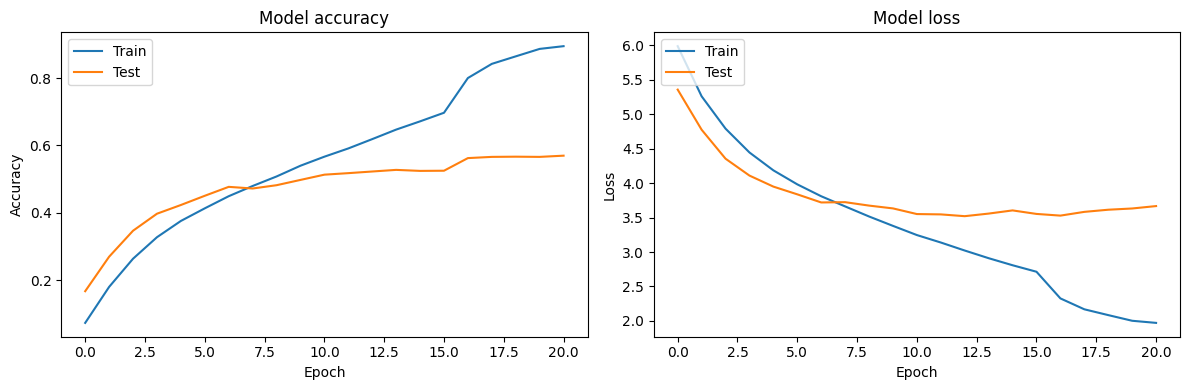

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()